In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
#         x = Dense(32, activation = 'relu')(x)
#         x = Dense(16, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.5 0.6]
 [0.8 0.4]
 [0.9 0.1]
 [0.1 0.2]
 [0.4 0.6]
 [0.2 0.7]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.0, 0.1, 0.3, 0.3] -1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([0], maxlen=1024)
deque([-1], maxlen=1024)
deque([[0.0, 0.1, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[-0.00202752  0.2065881   0.03520308  0.1549705 ]], shape=(1, 4), dtype=float32)


  0%|                                                                            | 120/100000 [00:00<10:30, 158.38it/s]

Updated Weights
Mean Reward = -2.4554455445544554
9


  0%|▏                                                                           | 224/100000 [00:01<11:54, 139.61it/s]

Updated Weights
Mean Reward = -2.8
5


  0%|▏                                                                            | 315/100000 [00:02<17:38, 94.14it/s]

Updated Weights
Mean Reward = -1.45
7


  0%|▎                                                                           | 414/100000 [00:03<15:54, 104.28it/s]

Updated Weights
Mean Reward = -1.06
7


  0%|▎                                                                           | 493/100000 [00:04<16:03, 103.25it/s]

Updated Weights
Mean Reward = -0.22
9


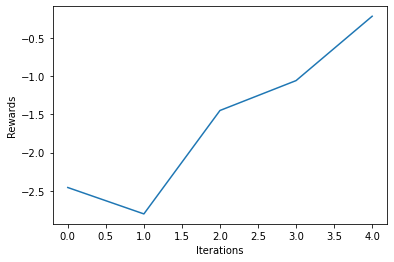

  1%|▍                                                                            | 617/100000 [00:05<20:20, 81.41it/s]

Updated Weights
Mean Reward = -1.63
7


  1%|▌                                                                            | 712/100000 [00:06<18:23, 89.97it/s]

Updated Weights
Mean Reward = -2.22
10


  1%|▋                                                                            | 812/100000 [00:08<24:02, 68.75it/s]

Updated Weights
Mean Reward = -2.42
10


  1%|▋                                                                            | 907/100000 [00:09<25:42, 64.23it/s]

Updated Weights
Mean Reward = -1.84
12


  1%|▊                                                                            | 993/100000 [00:10<24:06, 68.47it/s]

Updated Weights
Mean Reward = -4.31
8


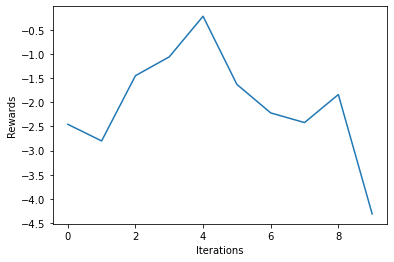

  1%|▊                                                                           | 1107/100000 [00:12<26:27, 62.28it/s]

Updated Weights
Mean Reward = -2.71
10


  1%|▉                                                                           | 1213/100000 [00:14<24:04, 68.39it/s]

Updated Weights
Mean Reward = -5.2
5


  1%|▉                                                                           | 1307/100000 [00:16<27:55, 58.91it/s]

Updated Weights
Mean Reward = -3.2
6


  1%|█                                                                           | 1413/100000 [00:17<26:22, 62.31it/s]

Updated Weights
Mean Reward = -2.63
15


  1%|█▏                                                                          | 1497/100000 [00:19<26:46, 61.31it/s]

Updated Weights
Mean Reward = -5.33
6


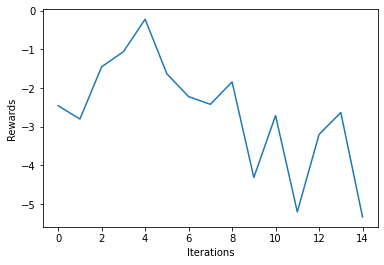

  2%|█▏                                                                          | 1610/100000 [00:21<30:06, 54.45it/s]

Updated Weights
Mean Reward = -6.76
8


  2%|█▎                                                                          | 1708/100000 [00:23<30:57, 52.93it/s]

Updated Weights
Mean Reward = -4.72
4


  2%|█▎                                                                          | 1806/100000 [00:25<31:36, 51.77it/s]

Updated Weights
Mean Reward = -4.91
3


  2%|█▍                                                                          | 1908/100000 [00:27<31:39, 51.65it/s]

Updated Weights
Mean Reward = -1.73
8


  2%|█▌                                                                          | 2000/100000 [00:28<30:00, 54.43it/s]

Updated Weights
Mean Reward = -0.93
16


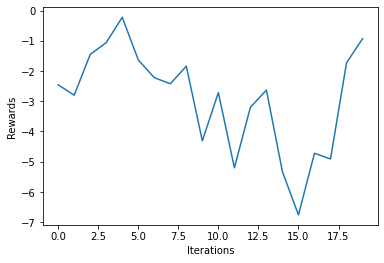

  2%|█▌                                                                          | 2108/100000 [00:31<30:23, 53.69it/s]

Updated Weights
Mean Reward = -1.97
13


  2%|█▋                                                                          | 2209/100000 [00:33<32:23, 50.32it/s]

Updated Weights
Mean Reward = -0.7
9


  2%|█▊                                                                          | 2307/100000 [00:35<33:07, 49.16it/s]

Updated Weights
Mean Reward = -0.11
14


  2%|█▊                                                                          | 2407/100000 [00:37<32:04, 50.71it/s]

Updated Weights
Mean Reward = -1.62
11


  2%|█▉                                                                          | 2496/100000 [00:38<32:10, 50.51it/s]

Updated Weights
Mean Reward = -0.61
8


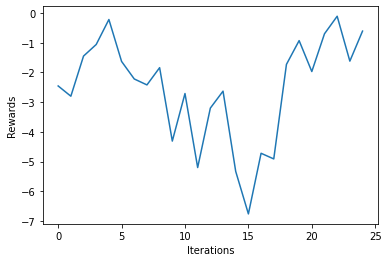

  3%|█▉                                                                          | 2607/100000 [00:41<35:23, 45.86it/s]

Updated Weights
Mean Reward = -0.28
7


  3%|██                                                                          | 2709/100000 [00:43<31:44, 51.09it/s]

Updated Weights
Mean Reward = -0.59
4


  3%|██▏                                                                         | 2804/100000 [00:45<35:20, 45.84it/s]

Updated Weights
Mean Reward = -0.59
5


  3%|██▏                                                                         | 2906/100000 [00:47<36:05, 44.83it/s]

Updated Weights
Mean Reward = -0.68
5


  3%|██▎                                                                         | 3000/100000 [00:49<33:21, 48.46it/s]

Updated Weights
Mean Reward = -0.61
4


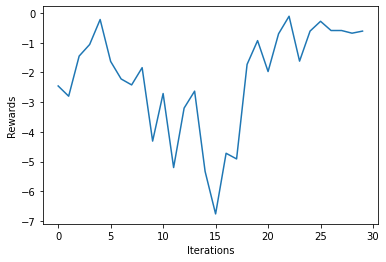

  3%|██▎                                                                         | 3110/100000 [00:52<35:34, 45.39it/s]

Updated Weights
Mean Reward = -0.52
2


  3%|██▍                                                                         | 3209/100000 [00:54<34:53, 46.22it/s]

Updated Weights
Mean Reward = -0.22
8


  3%|██▌                                                                         | 3306/100000 [00:56<36:09, 44.58it/s]

Updated Weights
Mean Reward = -0.8
5


  3%|██▌                                                                         | 3408/100000 [00:58<33:21, 48.26it/s]

Updated Weights
Mean Reward = 0.73
5


  3%|██▋                                                                         | 3495/100000 [01:00<34:27, 46.69it/s]

Updated Weights
Mean Reward = -0.71
7


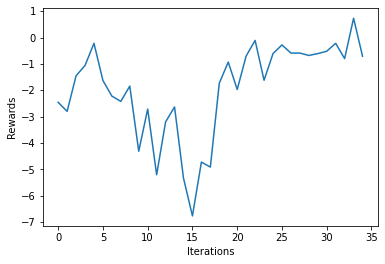

  4%|██▋                                                                         | 3604/100000 [01:03<34:25, 46.67it/s]

Updated Weights
Mean Reward = 1.39
11


  4%|██▊                                                                         | 3704/100000 [01:05<38:42, 41.46it/s]

Updated Weights
Mean Reward = -1.03
4


  4%|██▉                                                                         | 3809/100000 [01:08<37:17, 42.98it/s]

Updated Weights
Mean Reward = 0.01
2


  4%|██▉                                                                         | 3910/100000 [01:10<36:47, 43.54it/s]

Updated Weights
Mean Reward = 1.12
5


  4%|███                                                                         | 4000/100000 [01:12<38:41, 41.35it/s]

Updated Weights
Mean Reward = -0.13
3


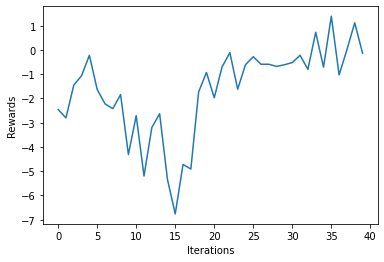

  4%|███                                                                         | 4109/100000 [01:15<38:14, 41.79it/s]

Updated Weights
Mean Reward = 1.29
7


  4%|███▏                                                                        | 4206/100000 [01:18<39:01, 40.92it/s]

Updated Weights
Mean Reward = 0.86
3


  4%|███▎                                                                        | 4306/100000 [01:20<39:04, 40.81it/s]

Updated Weights
Mean Reward = 0.96
4


  4%|███▎                                                                        | 4404/100000 [01:23<48:42, 32.71it/s]

Updated Weights
Mean Reward = 0.54
1


  4%|███▍                                                                        | 4499/100000 [01:25<44:55, 35.43it/s]

Updated Weights
Mean Reward = 0.91
2


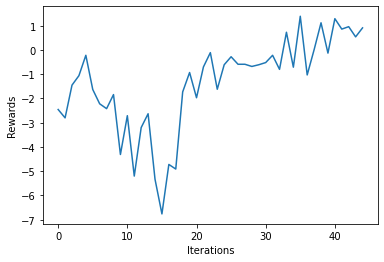

  5%|███▌                                                                        | 4607/100000 [01:29<42:03, 37.80it/s]

Updated Weights
Mean Reward = 2.19
6


  5%|███▌                                                                        | 4707/100000 [01:31<41:26, 38.32it/s]

Updated Weights
Mean Reward = 0.76
2


  5%|███▋                                                                        | 4805/100000 [01:34<39:01, 40.66it/s]

Updated Weights
Mean Reward = 1.85
3


  5%|███▋                                                                        | 4904/100000 [01:36<40:20, 39.29it/s]

Updated Weights
Mean Reward = 0.65
4


  5%|███▊                                                                        | 4996/100000 [01:39<38:49, 40.78it/s]

Updated Weights
Mean Reward = 2.4
5


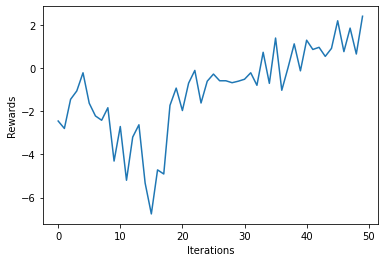

  5%|███▉                                                                        | 5104/100000 [01:42<43:38, 36.24it/s]

Updated Weights
Mean Reward = 0.69
1


  5%|███▉                                                                        | 5205/100000 [01:45<42:26, 37.23it/s]

Updated Weights
Mean Reward = -0.58
2


  5%|████                                                                        | 5307/100000 [01:47<41:59, 37.59it/s]

Updated Weights
Mean Reward = 2.81
8


  5%|████                                                                        | 5406/100000 [01:50<42:30, 37.09it/s]

Updated Weights
Mean Reward = 2.26
3


  5%|████▏                                                                       | 5497/100000 [01:52<45:16, 34.79it/s]

Updated Weights
Mean Reward = 2.29
5


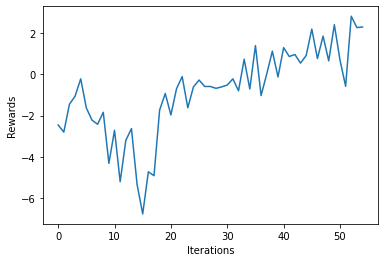

  6%|████▎                                                                       | 5605/100000 [01:55<41:02, 38.34it/s]

Updated Weights
Mean Reward = 1.08
3


  6%|████▎                                                                       | 5707/100000 [01:58<41:20, 38.02it/s]

Updated Weights
Mean Reward = 3.06
5


  6%|████▍                                                                       | 5806/100000 [02:01<40:17, 38.96it/s]

Updated Weights
Mean Reward = 2.21
4


  6%|████▍                                                                       | 5909/100000 [02:04<41:16, 37.99it/s]

Updated Weights
Mean Reward = 1.51
4


  6%|████▌                                                                       | 6000/100000 [02:06<42:03, 37.25it/s]

Updated Weights
Mean Reward = 3.39
11


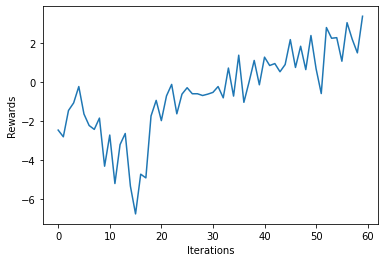

  6%|████▋                                                                       | 6107/100000 [02:09<37:47, 41.40it/s]

Updated Weights
Mean Reward = 1.03
12


  6%|████▋                                                                       | 6207/100000 [02:11<41:13, 37.93it/s]

Updated Weights
Mean Reward = 2.88
13


  6%|████▊                                                                       | 6305/100000 [02:14<38:37, 40.42it/s]

Updated Weights
Mean Reward = 2.77
11


  6%|████▊                                                                       | 6407/100000 [02:17<40:56, 38.10it/s]

Updated Weights
Mean Reward = 0.47
7


  6%|████▉                                                                       | 6496/100000 [02:19<42:04, 37.03it/s]

Updated Weights
Mean Reward = 2.22
7


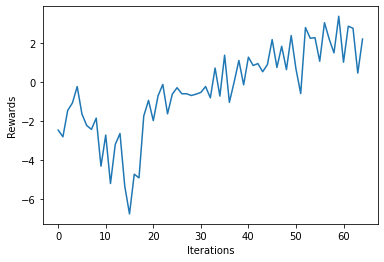

  7%|█████                                                                       | 6605/100000 [02:22<35:39, 43.65it/s]

Updated Weights
Mean Reward = 3.75
17


  7%|█████                                                                       | 6708/100000 [02:25<37:25, 41.54it/s]

Updated Weights
Mean Reward = 2.27
12


  7%|█████▏                                                                      | 6809/100000 [02:27<39:00, 39.81it/s]

Updated Weights
Mean Reward = 3.35
14


  7%|█████▏                                                                      | 6905/100000 [02:30<39:46, 39.01it/s]

Updated Weights
Mean Reward = 2.37
16


  7%|█████▎                                                                      | 6997/100000 [02:32<44:39, 34.72it/s]

Updated Weights
Mean Reward = 1.51
4


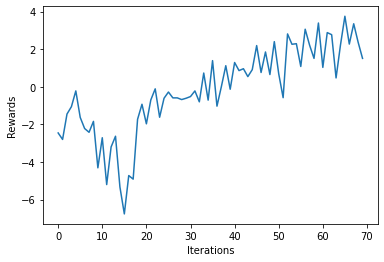

  7%|█████▍                                                                      | 7106/100000 [02:35<38:27, 40.25it/s]

Updated Weights
Mean Reward = 2.39
13


  7%|█████▍                                                                      | 7205/100000 [02:38<38:56, 39.72it/s]

Updated Weights
Mean Reward = 2.07
12


  7%|█████▌                                                                      | 7309/100000 [02:40<37:36, 41.08it/s]

Updated Weights
Mean Reward = 4.38
17


  7%|█████▋                                                                      | 7407/100000 [02:43<41:22, 37.29it/s]

Updated Weights
Mean Reward = 1.68
12


  8%|█████▋                                                                      | 7500/100000 [02:46<47:37, 32.37it/s]

Updated Weights
Mean Reward = 3.71
18


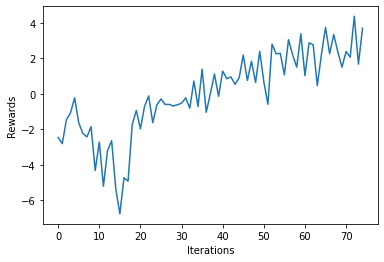

  8%|█████▊                                                                      | 7606/100000 [02:49<41:08, 37.44it/s]

Updated Weights
Mean Reward = 0.95
9


  8%|█████▊                                                                      | 7705/100000 [02:52<41:12, 37.32it/s]

Updated Weights
Mean Reward = 2.03
14


  8%|█████▉                                                                      | 7808/100000 [02:54<38:15, 40.16it/s]

Updated Weights
Mean Reward = 0.47
6


  8%|██████                                                                      | 7908/100000 [02:57<40:29, 37.91it/s]

Updated Weights
Mean Reward = 4.36
22


  8%|██████                                                                      | 8000/100000 [02:59<38:19, 40.01it/s]

Updated Weights
Mean Reward = 1.34
11


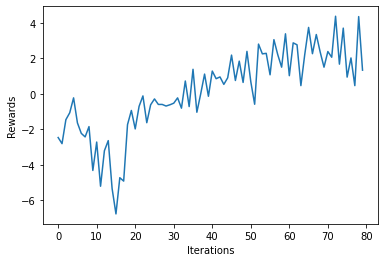

  8%|██████▏                                                                     | 8106/100000 [03:02<37:38, 40.68it/s]

Updated Weights
Mean Reward = 1.18
9


  8%|██████▏                                                                     | 8207/100000 [03:05<38:49, 39.40it/s]

Updated Weights
Mean Reward = 1.36
10


  8%|██████▎                                                                     | 8310/100000 [03:07<37:40, 40.57it/s]

Updated Weights
Mean Reward = 2.56
8


  8%|██████▍                                                                     | 8407/100000 [03:10<40:16, 37.91it/s]

Updated Weights
Mean Reward = 2.69
9


  8%|██████▍                                                                     | 8495/100000 [03:12<37:59, 40.15it/s]

Updated Weights
Mean Reward = 4.58
22


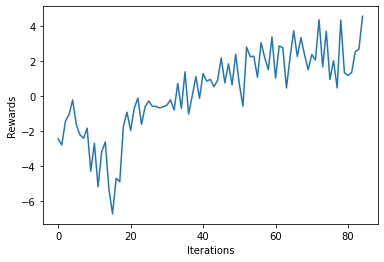

  9%|██████▌                                                                     | 8609/100000 [03:14<38:26, 39.62it/s]

Updated Weights
Mean Reward = 2.76
13


  9%|██████▌                                                                     | 8706/100000 [03:17<35:41, 42.63it/s]

Updated Weights
Mean Reward = 3.5
13


  9%|██████▋                                                                     | 8807/100000 [03:19<38:37, 39.36it/s]

Updated Weights
Mean Reward = 2.36
12


  9%|██████▊                                                                     | 8907/100000 [03:22<36:30, 41.58it/s]

Updated Weights
Mean Reward = 2.43
10


  9%|██████▊                                                                     | 8997/100000 [03:24<37:01, 40.97it/s]

Updated Weights
Mean Reward = 3.16
11


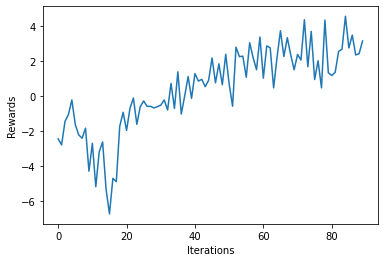

  9%|██████▉                                                                     | 9109/100000 [03:27<38:45, 39.09it/s]

Updated Weights
Mean Reward = 3.12
13


  9%|██████▉                                                                     | 9204/100000 [03:29<36:40, 41.26it/s]

Updated Weights
Mean Reward = 2.96
12


  9%|███████                                                                     | 9306/100000 [03:32<37:17, 40.53it/s]

Updated Weights
Mean Reward = 1.02
11


  9%|███████▏                                                                    | 9408/100000 [03:34<38:50, 38.88it/s]

Updated Weights
Mean Reward = 3.74
15


 10%|███████▏                                                                    | 9500/100000 [03:36<38:38, 39.04it/s]

Updated Weights
Mean Reward = 4.88
10


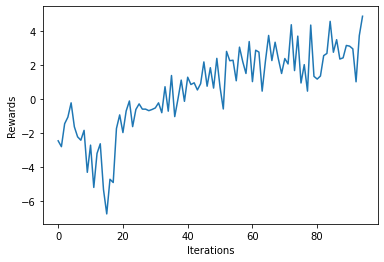

 10%|███████▎                                                                    | 9607/100000 [03:39<36:54, 40.82it/s]

Updated Weights
Mean Reward = 2.15
9


 10%|███████▍                                                                    | 9705/100000 [03:42<36:35, 41.12it/s]

Updated Weights
Mean Reward = 3.41
14


 10%|███████▍                                                                    | 9809/100000 [03:44<35:43, 42.08it/s]

Updated Weights
Mean Reward = 4.26
15


 10%|███████▌                                                                    | 9905/100000 [03:46<34:28, 43.55it/s]

Updated Weights
Mean Reward = 1.74
21


 10%|███████▌                                                                   | 10000/100000 [03:49<39:29, 37.98it/s]

Updated Weights
Mean Reward = 1.37
5


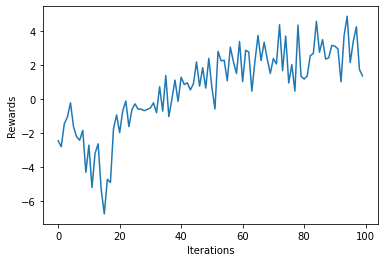

 10%|███████▌                                                                   | 10108/100000 [03:52<37:37, 39.82it/s]

Updated Weights
Mean Reward = 3.92
16


 10%|███████▋                                                                   | 10209/100000 [03:54<36:45, 40.71it/s]

Updated Weights
Mean Reward = 2.72
14


 10%|███████▋                                                                   | 10304/100000 [03:56<39:32, 37.81it/s]

Updated Weights
Mean Reward = 3.65
17


 10%|███████▊                                                                   | 10406/100000 [03:59<35:18, 42.29it/s]

Updated Weights
Mean Reward = 2.58
9


 10%|███████▊                                                                   | 10497/100000 [04:01<37:02, 40.26it/s]

Updated Weights
Mean Reward = 2.78
13


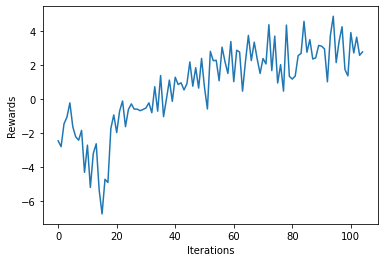

 11%|███████▉                                                                   | 10605/100000 [04:04<38:48, 38.40it/s]

Updated Weights
Mean Reward = 3.25
18


 11%|████████                                                                   | 10705/100000 [04:06<35:25, 42.01it/s]

Updated Weights
Mean Reward = 1.1
10


 11%|████████                                                                   | 10807/100000 [04:09<35:49, 41.50it/s]

Updated Weights
Mean Reward = 2.98
10


 11%|████████▏                                                                  | 10907/100000 [04:11<34:14, 43.37it/s]

Updated Weights
Mean Reward = 2.93
17


 11%|████████▎                                                                  | 11000/100000 [04:13<42:00, 35.31it/s]

Updated Weights
Mean Reward = 1.74
6


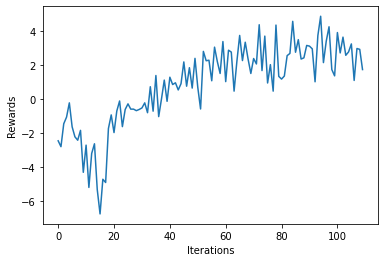

 11%|████████▎                                                                  | 11106/100000 [04:16<39:25, 37.58it/s]

Updated Weights
Mean Reward = 2.16
15


 11%|████████▍                                                                  | 11208/100000 [04:19<39:18, 37.65it/s]

Updated Weights
Mean Reward = 1.55
5


 11%|████████▍                                                                  | 11308/100000 [04:21<37:33, 39.37it/s]

Updated Weights
Mean Reward = 2.69
10


 11%|████████▌                                                                  | 11407/100000 [04:24<38:21, 38.49it/s]

Updated Weights
Mean Reward = 2.89
7


 12%|████████▋                                                                  | 11500/100000 [04:26<36:20, 40.59it/s]

Updated Weights
Mean Reward = 2.44
6


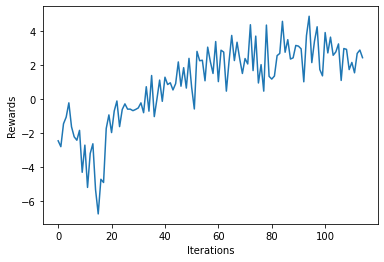

 12%|████████▋                                                                  | 11607/100000 [04:29<38:21, 38.41it/s]

Updated Weights
Mean Reward = 2.05
10


 12%|████████▊                                                                  | 11708/100000 [04:31<34:49, 42.25it/s]

Updated Weights
Mean Reward = 2.41
9


 12%|████████▊                                                                  | 11804/100000 [04:34<35:21, 41.57it/s]

Updated Weights
Mean Reward = 3.28
16


 12%|████████▉                                                                  | 11907/100000 [04:36<34:47, 42.21it/s]

Updated Weights
Mean Reward = 3.1
15


 12%|████████▉                                                                  | 11996/100000 [04:38<34:40, 42.30it/s]

Updated Weights
Mean Reward = 2.44
20


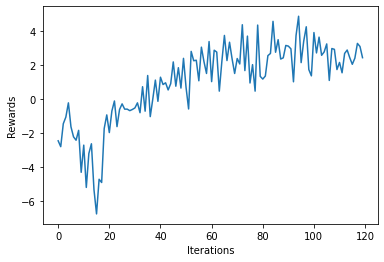

 12%|█████████                                                                  | 12108/100000 [04:41<35:29, 41.27it/s]

Updated Weights
Mean Reward = 3.55
14


 12%|█████████▏                                                                 | 12206/100000 [04:43<34:43, 42.14it/s]

Updated Weights
Mean Reward = 2.56
17


 12%|█████████▏                                                                 | 12306/100000 [04:46<30:11, 48.42it/s]

Updated Weights
Mean Reward = 3.56
24


 12%|█████████▎                                                                 | 12407/100000 [04:48<34:08, 42.75it/s]

Updated Weights
Mean Reward = 2.6
17


 12%|█████████▎                                                                 | 12495/100000 [04:50<34:38, 42.11it/s]

Updated Weights
Mean Reward = 3.83
17


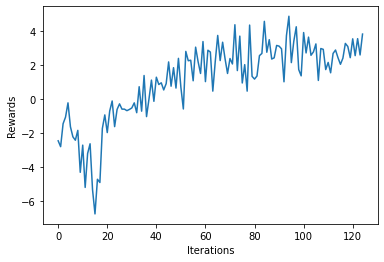

 13%|█████████▍                                                                 | 12607/100000 [04:53<33:38, 43.29it/s]

Updated Weights
Mean Reward = 3.07
14


 13%|█████████▌                                                                 | 12705/100000 [04:55<35:34, 40.89it/s]

Updated Weights
Mean Reward = 3.46
20


 13%|█████████▌                                                                 | 12806/100000 [04:58<37:12, 39.06it/s]

Updated Weights
Mean Reward = 3.36
12


 13%|█████████▋                                                                 | 12906/100000 [05:01<42:33, 34.11it/s]

Updated Weights
Mean Reward = 2.55
13


 13%|█████████▊                                                                 | 13000/100000 [05:03<48:21, 29.99it/s]

Updated Weights
Mean Reward = 3.79
15


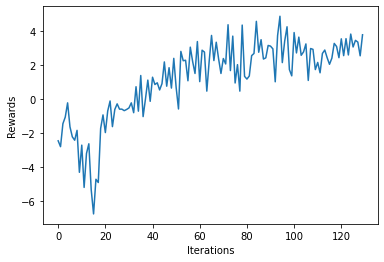

 13%|█████████▊                                                                 | 13109/100000 [05:06<39:52, 36.31it/s]

Updated Weights
Mean Reward = 2.18
14


 13%|█████████▉                                                                 | 13209/100000 [05:09<33:24, 43.29it/s]

Updated Weights
Mean Reward = 2.31
19


 13%|█████████▉                                                                 | 13307/100000 [05:11<39:21, 36.71it/s]

Updated Weights
Mean Reward = 2.49
14


 13%|██████████                                                                 | 13408/100000 [05:14<32:16, 44.71it/s]

Updated Weights
Mean Reward = 4.47
21


 13%|██████████                                                                 | 13498/100000 [05:16<37:40, 38.26it/s]

Updated Weights
Mean Reward = 1.95
12


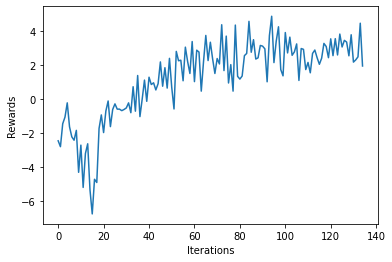

 14%|██████████▏                                                                | 13609/100000 [05:19<35:44, 40.29it/s]

Updated Weights
Mean Reward = 2.42
11


 14%|██████████▎                                                                | 13709/100000 [05:22<36:42, 39.18it/s]

Updated Weights
Mean Reward = 2.64
12


 14%|██████████▎                                                                | 13808/100000 [05:24<33:55, 42.35it/s]

Updated Weights
Mean Reward = 3.92
17


 14%|██████████▍                                                                | 13904/100000 [05:27<36:28, 39.35it/s]

Updated Weights
Mean Reward = 1.43
16


 14%|██████████▌                                                                | 14000/100000 [05:29<39:26, 36.33it/s]

Updated Weights
Mean Reward = 3.13
14


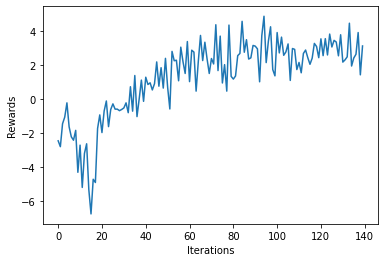

 14%|██████████▌                                                                | 14106/100000 [05:32<37:59, 37.69it/s]

Updated Weights
Mean Reward = 3.24
12


 14%|██████████▋                                                                | 14206/100000 [05:34<36:19, 39.37it/s]

Updated Weights
Mean Reward = 2.77
16


 14%|██████████▋                                                                | 14307/100000 [05:37<33:15, 42.94it/s]

Updated Weights
Mean Reward = 4.77
21


 14%|██████████▊                                                                | 14408/100000 [05:39<35:45, 39.90it/s]

Updated Weights
Mean Reward = 4.15
20


 14%|██████████▊                                                                | 14496/100000 [05:41<36:00, 39.58it/s]

Updated Weights
Mean Reward = 2.84
14


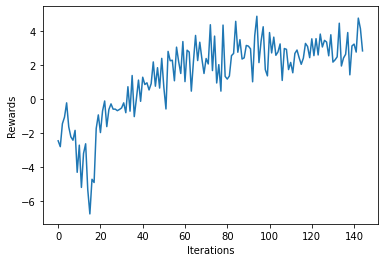

 15%|██████████▉                                                                | 14604/100000 [05:44<34:52, 40.82it/s]

Updated Weights
Mean Reward = 2.36
16


 15%|███████████                                                                | 14710/100000 [05:47<30:54, 46.00it/s]

Updated Weights
Mean Reward = 1.97
10


 15%|███████████                                                                | 14804/100000 [05:49<32:38, 43.51it/s]

Updated Weights
Mean Reward = 2.99
23


 15%|███████████▏                                                               | 14907/100000 [05:51<31:46, 44.62it/s]

Updated Weights
Mean Reward = 3.63
12


 15%|███████████▏                                                               | 14996/100000 [05:54<33:55, 41.76it/s]

Updated Weights
Mean Reward = 2.19
12


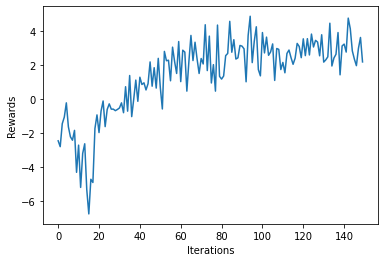

 15%|███████████▎                                                               | 15107/100000 [05:57<37:47, 37.44it/s]

Updated Weights
Mean Reward = 2.35
5


 15%|███████████▍                                                               | 15208/100000 [05:59<37:14, 37.95it/s]

Updated Weights
Mean Reward = 3.41
10


 15%|███████████▍                                                               | 15305/100000 [06:02<38:22, 36.79it/s]

Updated Weights
Mean Reward = 1.83
7


 15%|███████████▌                                                               | 15404/100000 [06:05<32:29, 43.39it/s]

Updated Weights
Mean Reward = 2.68
17


 16%|███████████▋                                                               | 15500/100000 [06:08<32:34, 43.24it/s]

Updated Weights
Mean Reward = 2.72
14


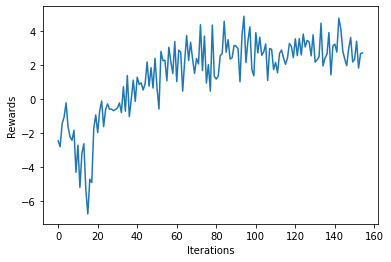

 16%|███████████▋                                                               | 15609/100000 [06:10<29:47, 47.20it/s]

Updated Weights
Mean Reward = 3.55
15


 16%|███████████▊                                                               | 15705/100000 [06:12<31:49, 44.13it/s]

Updated Weights
Mean Reward = 4.19
25


 16%|███████████▊                                                               | 15743/100000 [06:13<31:55, 43.99it/s]

In [ ]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
#         assert(np.allclose(user_agent.target_model.get_weights(),user_agent.model.get_weights()))
        print('Updated Weights')
#     print(user_agent.model.get_weights())
        
    
    if epoch>50 and epoch%250==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [ ]:
user_agent.model(np.array([[0.1, 0.1, 0.1 , 0.3]]))
# print(user_agent.replay_buffer.state_history[5])
# print(user_agent.replay_buffer.action_history[5])
# print(user_agent.replay_buffer.rewards_history[5])
# print(user_agent.replay_buffer.next_state_history[5])